# Import packages

In [1]:
# import packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
from geopy.distance import distance
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

# change display setting
pd.options.display.max_columns = 50

In [2]:
# load training data into data frame and remove dropoff_datetime

taxi_df = pd.read_csv('/Users/sethhowes/Desktop/DataScience/nyc-taxi-trip-duration/train.csv').drop(columns=["dropoff_datetime"])

# Exploratory data analysis

In [3]:
taxi_df.shape

(1458644, 10)

In [4]:
pd.set_option('display.float_format', lambda x: "{:.3f}".format(x))
taxi_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973,40.793,-73.973,40.783,N,435


In [5]:
# view data types of each column
taxi_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [6]:
# describe the data
taxi_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


The key summary statistics above indicate that there are some outliers in our data. For example, the minimum value for the trip duration is 1 second, and the maximum value is over 3.5 million seconds.

In [7]:
# assess the different values of vendor_id
taxi_df.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Having conducted an exploratory analysis above, these are my thoughts on each of the columns in terms of their suitability as features of a prediction model:

* `pickup_datetime` - this data is likely to be informative in predicting trip times. Trips are likely to take longer at rush hours, and will be shorter on the weekends where there people are not commuting to work. The time of year may also impact travel times, as the conditions on the roads may be worse in the winter, and therefore may take longer to drive on
* `vendor_id` - this is one of two values, and it might be worth calculating summary statistics to see if there are differences in travel time between these two vendors
* `passenger_count` - this may impact the duration of the trip, as multiple passengers may mean that the driver is having to drop each passenger off at a different location. In this case, the driver is unlikely to be taking the most direct route between pickup and dropoff locations, and therefore the journey may take longer
* `store_and_fwd_flag` - it is unclear what factors contribute to this being true or false. It may be that the server is not available in more builtup areas where tall buildings result in poorer reception. However this is not immediately clear
* `_latitude` and `_longitude` - these variables are likely to be the most informative in predicting travel times, as they can be used to calculate the distance of each journey

# Data cleaning

There is some immediate cleaning to be done on the data based upon my initial exploratory data analysis:

* Creation of additional variables with datetime properties separated
* Removal of anomalous trip times
* Removal of trips that fall outside the borders of New York

## Anomalous trip times

In [8]:
m = np.mean(taxi_df["trip_duration"])
s = np.std(taxi_df["trip_duration"])
taxi_df = taxi_df[taxi_df["trip_duration"] <= m + 2*s]
taxi_df = taxi_df[taxi_df["trip_duration"] >= m - 2*s]

In [9]:
taxi_df.shape

(1456540, 10)

## DateTime separation

In [10]:
# change pickup_datetime and dropoff_datetime to datetime data type
taxi_df["pickup_datetime"] = pd.to_datetime(taxi_df["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

taxi_df["pickup_hour"] = taxi_df["pickup_datetime"].dt.hour
taxi_df["pickup_day"] = taxi_df["pickup_datetime"].dt.dayofweek
taxi_df["pickup_week"] = taxi_df["pickup_datetime"].dt.isocalendar().week
taxi_df["pickup_month"] = taxi_df["pickup_datetime"].dt.month
taxi_df["pickup_date"] = taxi_df["pickup_datetime"].dt.date

## Latitude and longitude clean-up

From the key statistics table above, we can see that the range of latitudes and longitudes is far larger than the borders of New York City. As such, we will need to remove cases where pickup or dropoff locations are outside of the bounds of New York.

The bounds of New York City are as follows:
* Longitude: 74.03, -73.75
* Latitude: 40.63, 40.85

In [11]:
taxi_df = taxi_df[(taxi_df['pickup_longitude'] <= -73.75) & (taxi_df['pickup_longitude'] >= -74.03)]
taxi_df = taxi_df[(taxi_df['pickup_latitude'] <= 40.85) & (taxi_df['pickup_latitude'] >= 40.63)]
taxi_df = taxi_df[(taxi_df['dropoff_longitude'] <= -73.75) & (taxi_df['dropoff_longitude'] >= -74.03)]
taxi_df = taxi_df[(taxi_df['dropoff_latitude'] <= 40.85) & (taxi_df['dropoff_latitude'] >= 40.63)]

taxi_df.shape

(1437128, 15)

# Data visualisation

I now want to visualise trip times to gain a greater understanding of the distribution of the data.

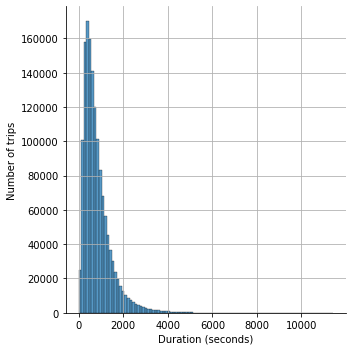

In [12]:
sns.displot(taxi_df, x="trip_duration", bins=100)
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of trips")
plt.grid()

#plt.rcParams['figure.figsize'] = [5, 5]
#plt.rcParams['figure.dpi'] = 150 

plt.show()

I also want to view trip druration over time, to see if there is seasonality to the data.

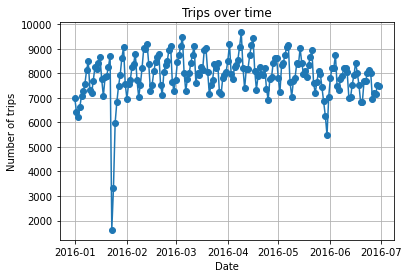

In [13]:
plt.plot(taxi_df.groupby('pickup_date').count()[['id']], '-o')
plt.xlabel("Date")
plt.ylabel("Number of trips")
plt.title("Trips over time")
plt.grid()
plt.show()

We also want to visualise whether trip durations vary by `vendor_id`.

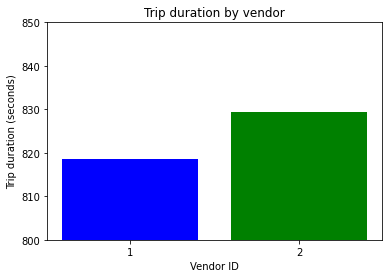

In [14]:
vendor_duration = taxi_df.groupby('vendor_id').trip_duration.mean()

plt.bar(vendor_duration.index, vendor_duration.values, color=['blue', 'green'])
plt.ylim((800, 850))
plt.xticks((1, 2))
plt.xlabel('Vendor ID')
plt.ylabel('Trip duration (seconds)')
plt.title('Trip duration by vendor')

plt.show()

I also want to assess whether there is a difference in trip duration by `store_and_fwd_flag`.

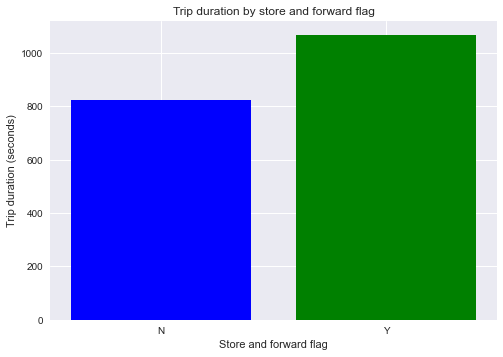

In [15]:
store_duration = taxi_df.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.style.use('seaborn')

plt.bar(store_duration.index, store_duration.values, color=['blue', 'green'])
plt.xlabel("Store and forward flag")
plt.ylabel("Trip duration (seconds)")
plt.title("Trip duration by store and forward flag")

plt.show()

As mentioned above, we also want to see whether the number of passengers alters trip duration.

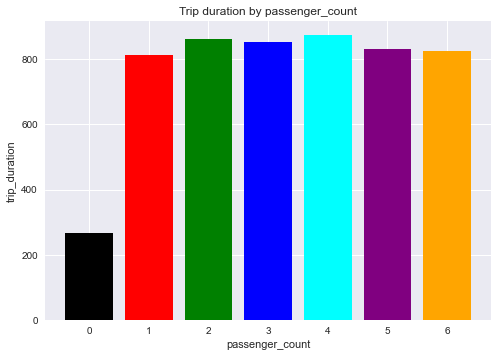

In [16]:
passenger_duration = taxi_df.groupby("passenger_count")['trip_duration'].mean()

plt.bar(passenger_duration.index, passenger_duration.values, color=['black', 'red', 'green', 'blue', 'cyan', 'purple', 'orange'])
plt.title("Trip duration by passenger_count")
plt.xlabel("passenger_count")
plt.ylabel("trip_duration")
plt.show()

It is clear that the trip_duration for a passenger_count of 0 is different to trips with any other passenger_count. I want to check the nunber of trips with a passenger_count of 0 to determine whether these trips are anomalous data points.

In [17]:
taxi_df.groupby("passenger_count").size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

The output above indicates that the trips with a passenger_count of 0 are likely anomalous, as there are only 52 trips with this count.

I now want to output spatial information about the trips. I can do this be plotting the latitudes and longitudes of a trip on a scatterplot.

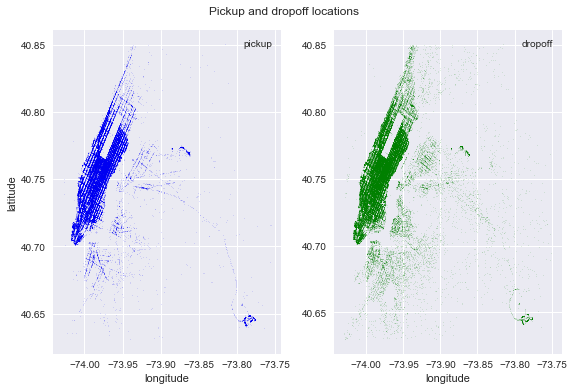

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.scatter(x=taxi_df['pickup_longitude'][:100000], y=taxi_df['pickup_latitude'][:100000], s=0.6,
            alpha=0.1, color='blue', label="pickup")

ax2.scatter(x=taxi_df['dropoff_longitude'][:100000], y=taxi_df["dropoff_latitude"][:100000], s=0.6,
            alpha=0.1, color='green', label="dropoff")

fig.suptitle('Pickup and dropoff locations')

ax1.set_ylabel("latitude")
ax1.set_xlabel("longitude")
ax2.set_xlabel("longitude")
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
fig.tight_layout()

plt.show()

# Geographical feature engineering

I will now proceed to do analysis on the data, beginning with geographical analysis. For this analysis, I have copied three functions from Beluga's solution to this project. The initial stage of their approach involves calculating two variables:
* Haversine distance - the great-circle distance along a sphere given the latitude and longitude of two points on the sphere
* Bearing - the direction of travel from pickup to dropoff location

In [19]:
def hsine_dist(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km

# calculate manhattan distance
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = hsine_dist(lat1, lng1, lat1, lng2)
    b = hsine_dist(lat1, lng1, lat2, lng1)
    return a + b

# create function for calculating bearing
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

Now that I have defined the above functions, I want to add two new columns to my data frame. The first is `hs_dist`, and the second is `bearing`.

In [20]:
# calculate haversine distance for each trip
taxi_df['hs_dist'] = taxi_df.apply(lambda x: dummy_manhattan_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

# calculate bearing for each trip
taxi_df['bearing'] = taxi_df.apply(lambda x: bearing_array(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

I will now sort values into neighborhoods using k-means clustering.

In [21]:
# vertical stack of dropoff and pickup coordinates
coords = np.vstack((taxi_df[['pickup_latitude', 'pickup_longitude']].values,
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']].values))

# indexes for sample of 500000 records
sample_ind = np.random.permutation(len(coords))[:500000]

# establish model
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000)

kmeans.fit(coords[sample_ind])

taxi_df['pickup_cluster'] = kmeans.predict(taxi_df[['pickup_latitude', 'pickup_longitude']])

taxi_df['dropoff_cluster'] = kmeans.predict(taxi_df[['dropoff_latitude', 'dropoff_longitude']])

In [22]:
taxi_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,pickup_week,pickup_month,pickup_date,hs_dist,bearing,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,1,-73.982,40.768,-73.965,40.766,N,455,17,0,11,3,2016-03-14,2.019,99.970,44,34
1,id2377394,1,2016-06-12 00:43:35,1,-73.980,40.739,-73.999,40.731,N,663,0,6,23,6,2016-06-12,2.346,-117.154,43,29
2,id3858529,2,2016-01-19 11:35:24,1,-73.979,40.764,-74.005,40.710,N,2124,11,1,3,1,2016-01-19,4.575,-159.680,44,4
3,id3504673,2,2016-04-06 19:32:31,1,-74.010,40.720,-74.012,40.707,N,429,19,2,14,4,2016-04-06,0.653,-172.738,67,46
4,id2181028,2,2016-03-26 13:30:55,1,-73.973,40.793,-73.973,40.783,N,435,13,5,12,3,2016-03-26,0.342,179.474,61,90


Now that we have gropued trips into clusters according to pickup and dropoff location, we will visualise this using a scatterplot.

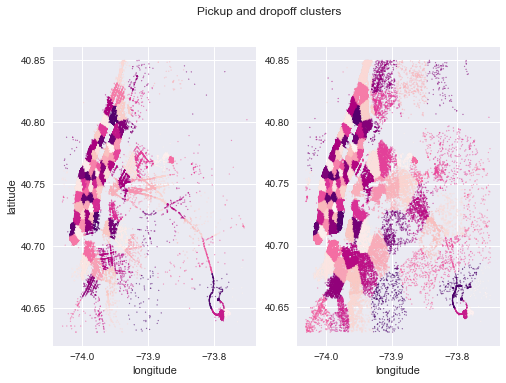

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.scatter(taxi_df['pickup_longitude'][:500000], taxi_df['pickup_latitude'][:500000],
            s=1, alpha=0.5, c=taxi_df['pickup_cluster'][:500000], cmap='RdPu')


ax2.scatter(taxi_df['dropoff_longitude'][:500000], taxi_df['dropoff_latitude'][:500000],
            s=1, alpha=0.5, c=taxi_df['dropoff_cluster'][:500000], cmap='RdPu')

fig.suptitle('Pickup and dropoff clusters')
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude')
ax2.set_xlabel('longitude')

plt.show()

# One-hot encoding

I want to establish whether it would be useful to one-hot encode datetime variables. To establish this, I will  visualise how average speed varies with:
* Hour of the day
* Day of the week
* Week of the year
* Month of the year

In [24]:
taxi_df['avg_spd'] = taxi_df.apply(lambda x: x['hs_dist'] / x['trip_duration'], axis=1)

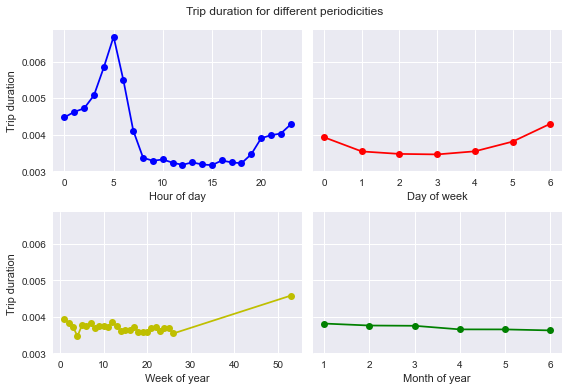

In [25]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=True)

ax1.plot(np.sort(taxi_df.pickup_hour.unique()), taxi_df.groupby('pickup_hour')['avg_spd'].mean(), '-bo')
ax2.plot(np.sort(taxi_df.pickup_day.unique()), taxi_df.groupby('pickup_day')['avg_spd'].mean(), '-ro')
ax3.plot(np.sort(taxi_df.pickup_week.unique()), taxi_df.groupby('pickup_week')['avg_spd'].mean(), '-yo')
ax4.plot(np.sort(taxi_df.pickup_month.unique()), taxi_df.groupby('pickup_month')['avg_spd'].mean(), '-go')

ax1.set_ylabel('Trip duration')
ax1.set_xlabel('Hour of day')
ax2.set_xlabel('Day of week')
ax3.set_xlabel('Week of year')
ax3.set_ylabel('Trip duration')
ax4.set_xlabel('Month of year')

fig.suptitle("Trip duration for different periodicities")

plt.tight_layout()
plt.show()

It is clear that trip duration varies with these different time variables, excluding week of year.

I will now proceed to one-hot encode the following columns:
* vendor_id
* passenger_count
* store_and_fwd_flag
* cluster_pickup
* cluster_dropoff
* pickup_hour
* day
* month

In [26]:
# list of features to one-hot encode
cat_features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_cluster', 'dropoff_cluster', 'pickup_hour', 'pickup_day', 'pickup_month']

taxi_df = pd.get_dummies(taxi_df, columns=cat_features, prefix=cat_features, prefix_sep='_')

# Tidying dataset 

I want to tidy the dataset an additional time to ensure that it is ready to train the model.

In [27]:
taxi_df.head()

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_week,pickup_date,hs_dist,bearing,avg_spd,vendor_id_1,vendor_id_2,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_cluster_0,pickup_cluster_1,...,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,pickup_day_0,pickup_day_1,pickup_day_2,pickup_day_3,pickup_day_4,pickup_day_5,pickup_day_6,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6
0,id2875421,2016-03-14 17:24:55,-73.982,40.768,-73.965,40.766,455,11,2016-03-14,2.019,99.970,0.004,0,1,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,id2377394,2016-06-12 00:43:35,-73.980,40.739,-73.999,40.731,663,23,2016-06-12,2.346,-117.154,0.004,1,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,id3858529,2016-01-19 11:35:24,-73.979,40.764,-74.005,40.710,2124,3,2016-01-19,4.575,-159.680,0.002,0,1,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,id3504673,2016-04-06 19:32:31,-74.010,40.720,-74.012,40.707,429,14,2016-04-06,0.653,-172.738,0.002,0,1,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,id2181028,2016-03-26 13:30:55,-73.973,40.793,-73.973,40.783,435,12,2016-03-26,0.342,179.474,0.001,0,1,0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


I am going to remove the following columns and save to a new object `training_df`:
* `id`
* `pickup_datetime`
* `pickup_week`
* `pickup_date`
* `pickup_latitude`
* `pickup_longitude`
* `dropoff_latitude`
* `dropoff_longitude`
* `avg_spd`

In [28]:
# remove columns
training_df = taxi_df.drop(columns=['id', 'pickup_datetime', 'pickup_week', 'pickup_date', 'pickup_latitude',
                                    'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'avg_spd'])

# Training model

In [29]:
# split first 100,000 records of dataset into train and test sets
train, test = train_test_split(training_df[:100000], test_size=0.2, random_state=1)

Split train and test sets into feature and outcome objects.

In [30]:
train_X = train.drop(columns="trip_duration")
train_y = train["trip_duration"]

test_X = test.drop(columns='trip_duration')
test_y = test['trip_duration']

Now I need to initialise the XGBoost matrices.

In [31]:
xgb_train_matrix = xgb.DMatrix(train_X, label=train_y)
xgb_test_matrix = xgb.DMatrix(test_X, label=test_y)
watchlist = [(xgb_train_matrix, 'train'), (xgb_test_matrix, 'valid')]

I need to establish a set of parameters to use to train the model.

In [32]:
# parameters with list of potential values to be looped through
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]

# train and validate model using additional features
for m in md:
    for l in lr:
        for n in mcw:
            print("md: {}, lr = {}, mcw: {}".format(m,l,n))
            xgb_pars = {'min_child_weight': m, 'eta': l, 'colsample_bytree': 0.9, 
                       'max_depth': m,
                        'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
                        'eval_metric': 'rmsle', 'objective': 'reg:linear'}
            model = xgb.train(xgb_pars, xgb_train_matrix, 50, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=1)

md: 6, lr = 0.1, mcw: 20
[15:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmsle:2.22074	valid-rmsle:2.22521
[1]	train-rmsle:1.60802	valid-rmsle:1.61117
[2]	train-rmsle:1.27784	valid-rmsle:1.28106
[3]	train-rmsle:1.06417	valid-rmsle:1.06737
[4]	train-rmsle:0.91375	valid-rmsle:0.91717
[5]	train-rmsle:0.80258	valid-rmsle:0.80638
[6]	train-rmsle:0.72109	valid-rmsle:0.72472
[7]	train-rmsle:0.65802	valid-rmsle:0.66158
[8]	train-rmsle:0.61212	valid-rmsle:0.61532
[9]	train-rmsle:0.57738	valid-rmsle:0.5

[46]	train-rmsle:0.46389	valid-rmsle:0.46923
[47]	train-rmsle:0.46327	valid-rmsle:0.46902
[48]	train-rmsle:0.46218	valid-rmsle:0.46796
[49]	train-rmsle:0.46137	valid-rmsle:0.46712
md: 6, lr = 0.3, mcw: 20
[15:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmsle:1.19442	valid-rmsle:1.19869
[1]	train-rmsle:0.74441	valid-rmsle:0.74772
[2]	train-rmsle:0.57356	valid-rmsle:0.57727
[3]	train-rmsle:0.50670	valid-rmsle:0.51034
[4]	train-rmsle:0.48437	valid-rmsle:0.48813
[5]	train-rmsle:0.47672	valid-rmsle

I will now output a barchart depicting the relative importance of each feature used to train the model.

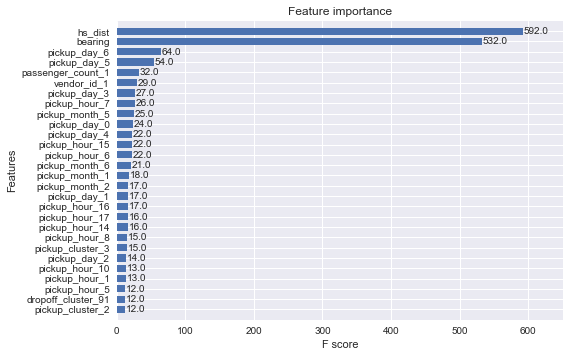

In [33]:
xgb.plot_importance(model, max_num_features=28, height=0.7)
plt.show()

# Extra features

I wanted to see how the weather could impact the performance of the model, however, I decided that I would prioritise including other features first, and did not get around to including these.

I want to find the earliest and latest dates for the data in our data frame. I will then search for climate data for these times at an hourly resolution.

In [14]:
print(taxi_df.pickup_datetime.min())
print(taxi_df.pickup_datetime.max())

2016-01-01 00:00:17
2016-06-30 23:59:39


In [89]:
# read weather dataframe
weather_df = pd.read_csv("/Users/sethhowes/Desktop/DataScience/nyc-taxi-trip-duration/noaa-weather-data-jfk-airport/jfk_weather_cleaned.csv")

In [16]:
# inspect weather data
weather_df.head()

,DATE,HOURLYVISIBILITY,HOURLYDRYBULBTEMPF,HOURLYWETBULBTEMPF,HOURLYDewPointTempF,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYStationPressure,HOURLYSeaLevelPressure,HOURLYPrecip,HOURLYAltimeterSetting,HOURLYWindDirectionSin,HOURLYWindDirectionCos,HOURLYPressureTendencyIncr,HOURLYPressureTendencyDecr,HOURLYPressureTendencyCons
0,2010-01-01 01:00:00,6.0,33.0,32.0,31.0,92.0,0.0,29.97,29.99,0.01,29.99,0.0,1.0,0,1,0
1,2010-01-01 02:00:00,6.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.02,29.99,0.0,1.0,0,1,0
2,2010-01-01 03:00:00,5.0,33.0,33.0,32.0,96.0,0.0,29.97,29.99,0.00,29.99,0.0,1.0,0,1,0
3,2010-01-01 04:00:00,5.0,33.0,33.0,32.0,96.0,0.0,29.95,29.97,0.00,29.97,0.0,1.0,0,1,0
4,2010-01-01 05:00:00,5.0,33.0,32.0,31.0,92.0,0.0,29.93,29.96,0.00,29.95,0.0,1.0,0,1,0


In [17]:
weather_df.dtypes

DATE                           object
HOURLYVISIBILITY              float64
HOURLYDRYBULBTEMPF            float64
HOURLYWETBULBTEMPF            float64
HOURLYDewPointTempF           float64
HOURLYRelativeHumidity        float64
HOURLYWindSpeed               float64
HOURLYStationPressure         float64
HOURLYSeaLevelPressure        float64
HOURLYPrecip                  float64
HOURLYAltimeterSetting        float64
HOURLYWindDirectionSin        float64
HOURLYWindDirectionCos        float64
HOURLYPressureTendencyIncr      int64
HOURLYPressureTendencyDecr      int64
HOURLYPressureTendencyCons      int64
dtype: object

In [18]:
# convert date column to datetime type
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# select range of dates for which we have corresponding taxi trip data
start_date = "01-01-2016"
end_date = "30-06-2016"

# add hourly datetime column to taxi_df
taxi_df["pickup_by_hour"] = taxi_df.apply(lambda r: r.pickup_datetime.replace(minute=0, second=0), axis=1)

# merge dfs
taxi_weather_df = pd.merge(taxi_df, weather_df, left_on="pickup_by_hour", right_on="DATE", how="left")